<a href="https://colab.research.google.com/github/Sanjuktaaich/Product-category-classification/blob/master/product_classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Installing keras-bert and keras adapter
!pip install -q keras-bert keras-rectified-adam
!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
!unzip -o uncased_L-12_H-768_A-12.zip

Archive:  uncased_L-12_H-768_A-12.zip
   creating: uncased_L-12_H-768_A-12/
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: uncased_L-12_H-768_A-12/vocab.txt  
  inflating: uncased_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: uncased_L-12_H-768_A-12/bert_config.json  


In [0]:
# Parameters

SEQ_LEN = 128
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4

In [0]:
# Pretrained model path
import os

pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

# TF_KERAS must be added to environment variables in order to use TPU
#os.environ['TF_KERAS'] = '1'

In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import tensorflow as tf
import timeit

# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [7]:
# load bert model
import codecs
from keras_bert import load_trained_model_from_checkpoint

token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

#with strategy.scope():
with tf.device('/device:GPU:0'):
    model = load_trained_model_from_checkpoint(
        config_path,
        checkpoint_path,
        training=True,
        trainable=True,
        seq_len=SEQ_LEN,
    )

Using TensorFlow backend.




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [9]:
!ls '/content/drive/My Drive/fashion_data/'

bert_model24.h5					      resnet_model23.h5
Design.gdoc					      test_images
images						      test_text_data.csv
product_data.json				      text
resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5  train_text.txt


In [10]:
datapath = '/content/drive/My Drive/fashion_data/text'
txtfiles = os.listdir(datapath)
txtlabels = [(x, i) for i,x in enumerate(txtfiles)]
print(txtlabels)
print(txtfiles)

[('TOPS', 0), ('DRESS', 1), ('SHORTS', 2), ('PANT', 3), ('SKIRT', 4), ('LINGERIE', 5), ('OUTERWEAR', 6), ('JUMPSUIT', 7), ('BAG', 8), ('JEWELRY', 9), ('SHOE', 10)]
['TOPS', 'DRESS', 'SHORTS', 'PANT', 'SKIRT', 'LINGERIE', 'OUTERWEAR', 'JUMPSUIT', 'BAG', 'JEWELRY', 'SHOE']


In [0]:
# prepare data as numpy array and split to test and train
import os
import numpy as np
from tqdm import tqdm
from keras_bert import Tokenizer
import pandas as pd

tokenizer = Tokenizer(token_dict)


def load_data(path, labels):
    global tokenizer
    indices, sentiments = [], []
    for folder, sentiment in labels:
        folder = os.path.join(path, folder)
        for name in tqdm(os.listdir(folder)):
            with open(os.path.join(folder, name), 'r', encoding="utf-8", errors='ignore') as reader:
                  text = reader.read()
            ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
            indices.append(ids)
            sentiments.append(sentiment)
    items = list(zip(indices, sentiments))
    
    np.random.shuffle(items)
    test_items = items[int(0.8*len(items)):]
    train_items = items[:int(0.8*len(items))]
    indices_test, sentiments_test = zip(*test_items)
    indices_train, sentiments_train = zip(*train_items)
    indices_train = np.array(indices_train)
    indices_test = np.array(indices_test)
    mod_train = indices_train.shape[0] % BATCH_SIZE
    mod_test = indices_test.shape[0] % BATCH_SIZE
    if mod_train > 0:
        indices_train, sentiments_train = indices_train[:-mod_train], sentiments_train[:-mod_train]
    if mod_test > 0:
      indices_test, sentiments_test = indices_test[:-mod_test], sentiments_test[:-mod_test]

    return [indices_train, np.zeros_like(indices_train)], np.array(sentiments_train),[indices_test, np.zeros_like(indices_test)], np.array(sentiments_test)
  
train_path = datapath

train_x, train_y, test_x, test_y = load_data(train_path, labels)

100%|██████████| 301/301 [01:31<00:00,  4.40it/s]


In [0]:
# run if only testing
from keras_bert import Tokenizer
import pandas as pd

tokenizer = Tokenizer(token_dict)

1856


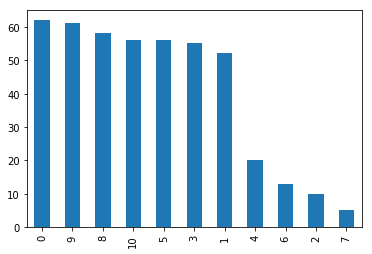

In [0]:
print(len(train_x[0]))
pd.Series(test_y).value_counts().plot(kind = 'bar')

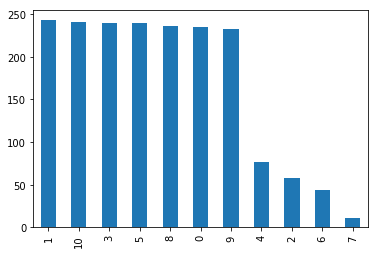

In [0]:
pd.Series(train_y).value_counts().plot(kind = 'bar')

In [12]:
# Build Custom Model
#from tensorflow.python import keras
import keras
from keras_radam import RAdam
#from keras_bert import get_custom_objects

#with strategy.scope():
with tf.device('/device:GPU:0'): 
  inputs = model.inputs[:2]
  dense = model.get_layer('NSP-Dense').output
  #print(dense)
  outputs = keras.layers.Dense(units=11, activation='softmax')(dense)
  model = keras.models.Model(inputs, outputs)
  model.compile(
        RAdam(learning_rate=LR),
        loss='sparse_categorical_crossentropy',
        metrics=['sparse_categorical_accuracy'],
  )

In [0]:
#  Initialize Variables
import tensorflow as tf
import tensorflow.keras.backend as K

sess = tf.Session(config=config)
try:
  sess.run(tf.global_variables_initializer())
except tf.errors.InvalidArgumentError:
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise

In [0]:
# Fit
with tf.device('/device:GPU:0'): 
  model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
  )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
1856/1856 [==============================] - 112s 60ms/step - loss: 1.8674 - sparse_categorical_accuracy: 0.4332
Epoch 2/10
1856/1856 [==============================] - 94s 51ms/step - loss: 0.3782 - sparse_categorical_accuracy: 0.9246
Epoch 3/10
1856/1856 [==============================] - 94s 51ms/step - loss: 0.1298 - sparse_categorical_accuracy: 0.9741
Epoch 4/10
1856/1856 [==============================] - 94s 51ms/step - loss: 0.0971 - sparse_categorical_accuracy: 0.9747
Epoch 5/10
1856/1856 [==============================] - 94s 51ms/step - loss: 0.0698 - sparse_categorical_accuracy: 0.9806
Epoch 6/10
1856/1856 [==============================] - 94s 51ms/step - loss: 0.0628 - sparse_categorical_accuracy: 0.9817
Epoch 7/10
1856/1856 [==============================] - 94s 51ms/step - loss: 0.0577 - sparse_categorical_accuracy: 0.9817
Epoch 8/10
1856/1856 [======================

In [0]:
model.save_weights("/content/drive/My Drive/fashion_data/bert_model24.h5")

In [0]:
model.load_weights("/content/drive/My Drive/fashion_data/bert_model24.h5")

In [13]:
# @title Predict

predicts = model.predict(test_x, verbose=True).argmax(axis=-1)

NameError: ignored

In [0]:
# @title Accuracy

print(np.sum(test_y == predicts) / test_y.shape[0])

0.9776785714285714


In [0]:
def get_label(index, labels):
    for each in labels:
        if index == each[1]:
            return each[0]

In [0]:
test = ""
ids, segments = tokenizer.encode(test, max_len=SEQ_LEN)

In [78]:
import numpy as np

inpu = np.array(ids).reshape([1, SEQ_LEN])
print(get_label(model.predict([inpu,np.zeros_like(inpu)]).argmax(axis=-1)[0], txtlabels))
print(model.predict([inpu,np.zeros_like(inpu)]).max(axis=-1)[0])
print(model.predict([inpu,np.zeros_like(inpu)]))

TOPS
0.33979157
[[0.33979157 0.18715666 0.18003884 0.0793896  0.00935852 0.0018891
  0.01829106 0.0063117  0.05456894 0.06526829 0.05793573]]


In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print('Confusion Matrix')
print(confusion_matrix(test_y, predicts))
#labels = test_generator.class_indices
#labels = labels.keys()
print('Classification Report')
L = [i[0] for i in labels]
print(classification_report(test_y, predicts, target_names=L))

Confusion Matrix
[[62  0  0  0  0  0  0  0  0  0  0]
 [ 0 52  0  0  0  0  0  0  0  0  0]
 [ 1  0  9  0  0  0  0  0  0  0  0]
 [ 2  0  0 51  2  0  0  0  0  0  0]
 [ 0  0  1  0 19  0  0  0  0  0  0]
 [ 0  0  0  0  0 56  0  0  0  0  0]
 [ 1  0  1  0  0  0 10  0  0  0  1]
 [ 0  0  0  0  0  0  0  5  0  0  0]
 [ 0  0  0  0  0  1  0  0 57  0  0]
 [ 0  0  0  0  0  0  0  0  0 61  0]
 [ 0  0  0  0  0  0  0  0  0  0 56]]
Classification Report
              precision    recall  f1-score   support

        TOPS       0.94      1.00      0.97        62
       DRESS       1.00      1.00      1.00        52
      SHORTS       0.82      0.90      0.86        10
        PANT       1.00      0.93      0.96        55
       SKIRT       0.90      0.95      0.93        20
    LINGERIE       0.98      1.00      0.99        56
   OUTERWEAR       1.00      0.77      0.87        13
    JUMPSUIT       1.00      1.00      1.00         5
         BAG       1.00      0.98      0.99        58
     JEWELRY       1.00

In [0]:
predicts[0]

10

In [16]:
# Load ResNet model

from tensorflow.python.keras.models import load_model

resnet_model = load_model('/content/drive/My Drive/fashion_data/resnet_model23.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [17]:
# test on train images
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = data_generator_no_aug.flow_from_directory(
                '/content/drive/My Drive/fashion_data/images/train',
                target_size=(image_size, image_size),
                class_mode=None,
                shuffle=False)
train_generator.reset()

imglabels = train_generator.class_indices
print(imglabels)

Found 2761 images belonging to 11 classes.
{'BAG': 0, 'DRESS': 1, 'JEWELRY': 2, 'JUMPSUIT': 3, 'LINGERIE': 4, 'OUTERWEAR': 5, 'PANT': 6, 'SHOE': 7, 'SHORTS': 8, 'SKIRT': 9, 'TOPS': 10}


In [0]:
imglabels = [(key, val) for key, val in imglabels.items()]

In [79]:
# Test on test data
from PIL import Image
from bs4 import BeautifulSoup
import json
import re

imgpath = '/content/drive/My Drive/fashion_data/test_images/test/'

with open('/content/drive/My Drive/fashion_data/product_data.json', 'r+') as json_file:
  data = json.load(json_file)
  for i, product in enumerate(data):
    text = BeautifulSoup(product['description']).text
    cleanText = re.sub(r'[^A-Za-z]', ' ', text)
    
    img = np.array(Image.open(imgpath + str(i) + '.jpg').resize((224, 224), Image.ANTIALIAS))
    img = np.reshape(img,[1,224,224,3])
    img_prediction = resnet_model.predict(img)
    img_val = prediction.max(axis=-1)[0]
      
    ids, segments = tokenizer.encode(cleanText, max_len=SEQ_LEN)
    inpu = np.array(ids).reshape([1, SEQ_LEN])
    txt_prediction = model.predict([inpu, np.zeros_like(inpu)])
    txt_val = prediction.max(axis=-1)[0]
    
    if img_val < 0.33 and txt_val < 0.33:
      label = 'OTHER'
    elif img_val > txt_val:
      label = get_label(img_prediction.argmax(axis=-1)[0], imglabels)
    else:
      label = get_label(txt_prediction.argmax(axis=-1)[0], txtlabels)
    data[i]['category'] = label
    print(i, cleanText, label)
  json_file.seek(0)
  json.dump(data, json_file)
  json_file.truncate()  

0 Nylon  brushed leather Two leather handles Detachable adjustable leather shoulder strap Triangle logo and leather screen printed logo Two way zipper closure on the top Nylon lining One zipper pocket inside PANT
1 Straight design  Fabric with cotton  Zip and hook fastening  Two side pockets  Two welt pockets on the back SHORTS
2 Fuzzy tinsel knit with a soft feel and look  Now in an updated  cropped silhouette    LF      tab Details Fit  tab  We recommend taking your regular size  Model is      wearing a size S      Polyamide      Wool  SHORTS
3      Leather  Decorative straps  Wide heel    cm heel  Square toed SHOE
4 Tringular design  Elastic  Animal print  Bow fastening on the neck and back  Inner lining SHORTS
5      Suede  Rounded toe  Side zip fastening    cm heel SHOE
6 Acetate frame front in Medium Tortoiseshell Frame compatible with graduated lenses      UVA   UVB protection Standard Fit Lens nose temple measurement             mm Article comes with dedicated packaging SHORTS


In [31]:
from PIL import Image

imgpath = '/content/drive/My Drive/fashion_data/test_images/test/'
img = np.array(Image.open(imgpath + str(1) + '.jpg').resize((224, 224), Image.ANTIALIAS))
img = np.reshape(img,[1,224,224,3])
print(resnet_model.predict(img))
print(resnet_model.predict(img).argmax(axis=-1)[0])
print(get_label(6, imglabels))

[[1.1334826e-03 1.0554062e-02 1.0141842e-03 4.5669262e-04 7.7400953e-03
  2.8314697e-02 6.4681375e-01 6.8897856e-03 1.0104879e-01 1.7211929e-01
  2.3915239e-02]]
6
PANT


In [71]:
txt = '100% Leather, Decorative straps, Wide heel, 7 cm heel, Square toed'

img = np.array(Image.open(imgpath + str(3) + '.jpg').resize((224, 224), Image.ANTIALIAS))
img = np.reshape(img,[1,224,224,3])
img_prediction = resnet_model.predict(img)
img_val = prediction.max(axis=-1)[0]
      
ids, segments = tokenizer.encode(txt, max_len=SEQ_LEN)
inpu = np.array(ids).reshape([1, SEQ_LEN])
txt_prediction = model.predict([inpu, np.zeros_like(inpu)])
txt_val = prediction.max(axis=-1)[0]
    
if img_val < 0.3 and txt_val < 0.3:
  label = 'OTHER'
elif img_val > txt_val:
  label = get_label(img_prediction.argmax(axis=-1)[0], imglabels)
else:
  label = get_label(txt_prediction.argmax(axis=-1)[0], txtlabels)
print(label)
print(txt_val)

SHOE
0.35187748
